## Running MOVE and analyze the latent space

This notebook runs part of the Multi-Omics Variational autoEncoder (MOVE) framework for training the model for integrating the data into the latent space, plotting the results and analyse the important variables for the integration- Before running this code the optimal hyperparameters need to be identified as described in the notebookes <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i> and <i>MOVE_hyperparameter_optimization_stability.ipynb</i>.

In [18]:
# !pip install statsmodels

In [19]:
# Load functions
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
from collections import defaultdict
import scipy
from scipy import stats
from statsmodels.stats.multitest import multipletests
from functools import reduce
import umap

import matplotlib
import matplotlib.pyplot as plt
import random
import copy
import scipy
from scipy import stats
matplotlib.use('agg')
plt.style.use('seaborn-whitegrid')

import warnings
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator

import os, sys
import torch
import numpy as np
from torch.utils import data
import re 

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset

In [20]:
# Functions for plotting

def embedding_plot_discrete(embedding, _type, name, file, palette=None):
   fig = plt.figure(figsize=(12,8))
   if palette == None:
      palette = sns.color_palette('colorblind', len(np.unique(_type)))
   
   ax = sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=_type,
                        palette = palette,
                        linewidth=0.1, alpha = 0.8, s=40, edgecolor = 'black')
                        
   
   box = ax.get_position()
   ax.set_position([box.x0, box.y0, box.width * 0.80, box.height]) # resize position
   
   legend_format = {name: np.unique(_type)}
   leg = subtitle_legend(ax, legend_format=legend_format)
   
   plt.xlabel('Dim1')
   plt.ylabel('Dim2')
   plt.style.use('default')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(True)
   ax.spines['bottom'].set_visible(True)
   
   plt.savefig(file)

def embedding_plot_float(embedding, type, name, file):
   fig, ax = plt.subplots(figsize=(12,8))
   points = ax.scatter(x=embedding[:,0], y=embedding[:,1], c=type, s=40, cmap="Spectral_r",
                       edgecolor = 'black', linewidth=0.1)
   
   cbar = fig.colorbar(points, fraction=0.03, pad=0.03)
   cbar.ax.set_title(name, rotation=0, fontsize = 16)
   
   box = ax.get_position()
   ax.set_position([box.x0, box.y0, box.width * 0.90, box.height])
   
   plt.xlabel('Dim1')
   plt.ylabel('Dim2')
   plt.style.use('default')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(True)
   ax.spines['bottom'].set_visible(True)
   
   plt.savefig(file)


def subtitle_legend(ax, legend_format):
   new_handles = []
   
   handles, labels = ax.get_legend_handles_labels()
   label_dict = dict(zip(labels, handles))
   
   #Means 2 labels were the same
   if len(label_dict) != len(labels):
       raise ValueError("Can not have repeated levels in labels!")
     
   for subtitle, level_order in legend_format.items():
       #Roll a blank handle to add in the subtitle
       blank_handle = matplotlib.patches.Patch(visible=False, label=subtitle)
       new_handles.append(blank_handle)
       
       for level in level_order:
           handle = label_dict[str(level)]
           new_handles.append(handle)
   
   #Labels are populated from handle.get_label() when we only supply handles as an arg
   legend = ax.legend(handles=new_handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                  fontsize = 14)
   #Turn off DrawingArea visibility to left justify the text if it contains a subtitle
   for draw_area in legend.findobj(matplotlib.offsetbox.DrawingArea):
       for handle in draw_area.get_children():
           if handle.get_label() in legend_format:
               draw_area.set_visible(False)
   
   return legend


In [21]:
# Functions for reading data
def read_cat(file):
   data = np.load(file)
   data = data.astype(np.float32)
   data_input = data.reshape(data.shape[0], -1)
   return data, data_input

def read_con(file):
   data = np.load(file)
   data = data.astype(np.float32)
   data[np.isnan(data)] = 0
   consum = data.sum(axis=0)
   mask_col = consum != 0
   data = data[:,mask_col]
   return data, mask_col

def read_header(file, mask=None, start=1):
   with open(file, "r") as f:
      h = f.readline().rstrip().split("\t")[start:]
   if not mask is None:
      h = np.array(h)
      h = h[mask]
   return h

In [22]:
# Load MOVE specific funtions and SHAP analysis
path = "./"
sys.path.append(path + "src/")
import VAE_v2_1
import plot_importance

Read in the data processed by <i>encode_data.ipynb</i>

In [23]:
# path = './'
# # Read in categorical data
# cat, cat_input = read_cat(path + "data/baseline_categorical.npy")
# cat_h = read_header(path + "data/baseline_categorical.tsv", start=1)

# geno, geno_input = read_cat(path + "data/diabetes_genotypes.npy")
# geno_h = read_header(path + "data/diabetes_genotypes.tsv", start=1)

# drug, drug_input = read_cat(path + "data/baseline_drugs.npy")
# drug_h = read_header(path + "data/baseline_drugs.tsv",start=1)

# # Read in continuous data
# con, con_mask = read_con(path + "data/baseline_continuous.npy")
# con_h = read_header(path + "data/baseline_continuous.tsv", con_mask)

# diet_wearables, con_mask = read_con(path + "data/baseline_diet_wearables.npy")
# diet_wearables_h = read_header(path + "data/baseline_diet_wearables.tsv", con_mask)

# pro, con_mask = read_con(path + "data/baseline_proteomic_antibodies.npy")
# pro_h = read_header(path + "/data/baseline_proteomic_antibodies.tsv", con_mask)
# pro_h = [s + "_pro" for s in pro_h] # due to overlap in gene names form transcriptomics data

# target_mata, con_mask = read_con(path + "data/baseline_target_metabolomics.npy")
# targm_h = read_header(path + "data/baseline_target_metabolomics.tsv", con_mask)

# untarget_mata, con_mask = read_con(path + "data/baseline_untarget_metabolomics.npy")
# untargm_h = read_header(path + "data/baseline_untarget_metabolomics.tsv", con_mask)

# trans, con_mask = read_con(path + "data/baseline_transcriptomics.npy")
# tran_h = read_header(path + "data/baseline_transcriptomics.tsv", con_mask)

# metagen, con_mask = read_con(path + "data/baseline_metagenomics.npy")
# meta_h = read_header(path + "data/baseline_metagenomics.tsv", con_mask)

Initialize varriables and make model using the identified optimal hyperparameters from the optimzsation steps. Here using equal weight for all continuous but double weight on the clinical data to ensure sufficient learning and focus of the structure of interested (Type 2 Dieabetes). 

In [30]:
# def get_data_headers(path):
#     cat_h = read_header(path + "data/baseline_categorical.tsv", start=1)
#     geno_h = read_header(path + "data/diabetes_genotypes.tsv", start=1)
#     drug_h = read_header(path + "data/baseline_drugs.tsv",start=1)
#     con_h = read_header(path + "data/baseline_continuous.tsv", con_mask)
#     diet_wearables_h = read_header(path + "data/baseline_diet_wearables.tsv", con_mask)
    
#     pro_h = read_header(path + "/data/baseline_proteomic_antibodies.tsv", con_mask)
#     pro_h = [s + "_pro" for s in pro_h] # due to overlap in gene names form transcriptomics data
#     targm_h = read_header(path + "data/baseline_target_metabolomics.tsv", con_mask)
#     untargm_h = read_header(path + "data/baseline_untarget_metabolomics.tsv", con_mask)
#     tran_h = read_header(path + "data/baseline_transcriptomics.tsv", con_mask)
#     meta_h = read_header(path + "data/baseline_metagenomics.tsv", con_mask)
    
#     headers_con = np.concatenate((con_h, diet_wearables_h, pro_h, targm_h, untargm_h, tran_h, meta_h)) #TODOs: is it really needed this change?
#     con_names = list(map(lambda b: b.replace("CRF_2_100_",""), headers_con))
#     con_names = np.array(list(map(lambda b: b.replace("CRF_2_102_",""), con_names)))

#     cat_names = np.concatenate((cat_h, geno_h, drug_h))

#     return(con_names, cat_names)
    
# def get_data(path):
    
#     #Reading the data
#     cat, cat_input = read_cat(path + "data/baseline_categorical.npy")
#     geno, geno_input = read_cat(path + "data/diabetes_genotypes.npy")
#     drug, drug_input = read_cat(path + "data/baseline_drugs.npy")
    
#     con, con_mask = read_con(path + "data/baseline_continuous.npy")
#     diet_wearables, con_mask = read_con(path + "data/baseline_diet_wearables.npy")
#     pro, con_mask = read_con(path + "data/baseline_proteomic_antibodies.npy")
#     target_mata, con_mask = read_con(path + "data/baseline_target_metabolomics.npy")
#     untarget_mata, con_mask = read_con(path + "data/baseline_untarget_metabolomics.npy")
#     trans, con_mask = read_con(path + "data/baseline_transcriptomics.npy")
#     metagen, con_mask = read_con(path + "data/baseline_metagenomics.npy")
    
#     con_list = [con, diet_wearables, pro, target_mata, untarget_mata, trans, metagen]
#     cat_list = [cat, geno, drug]
    
#     return(con_list, cat_list)


def get_data(path = './'):
    # Read in categorical data
    cat, cat_input = read_cat(path + "data/baseline_categorical.npy")
    cat_h = read_header(path + "data/baseline_categorical.tsv")

    geno, geno_input = read_cat(path + "data/diabetes_genotypes.npy")
    geno_h = read_header(path + "data/diabetes_genotypes.tsv")

    drug, drug_input = read_cat(path + "data/baseline_drugs.npy")
    drug_h = read_header(path + "data/baseline_drugs.tsv")


    # Read in continuous data
    con, con_mask = read_con(path + "data/baseline_continuous.npy")
    con_h = read_header(path + "data/baseline_continuous.tsv", con_mask)

    diet_wearables, con_mask = read_con(path + "data/baseline_diet_wearables.npy")
    diet_wearables_h = read_header(path + "data/baseline_diet_wearables.tsv", con_mask)

    pro, con_mask = read_con(path + "data/baseline_proteomic_antibodies.npy")
    pro_h = read_header(path + "data/baseline_proteomic_antibodies.tsv", con_mask)
    pro_h = [s + "_pro" for s in pro_h] # due to overlap in gene names form transcriptomics data

    target_mata, con_mask = read_con(path + "data/baseline_target_metabolomics.npy")
    targm_h = read_header(path + "data/baseline_target_metabolomics.tsv", con_mask)

    untarget_mata, con_mask = read_con(path + "data/baseline_untarget_metabolomics.npy")
    untargm_h = read_header(path + "data/baseline_untarget_metabolomics.tsv", con_mask)

    trans, con_mask = read_con(path + "data/baseline_transcriptomics.npy")
    tran_h = read_header(path + "data/baseline_transcriptomics.tsv", con_mask)

    metagen, con_mask = read_con(path + "data/baseline_metagenomics.npy")
    meta_h = read_header(path + "data/baseline_metagenomics.tsv", con_mask)
    
    # Get the headers file
    headers_con_tuple = (con_h, diet_wearables_h, pro_h, targm_h, untargm_h, tran_h, meta_h)
    headers_all_tuple = (cat_h, geno_h, drug_h, con_h, diet_wearables_h,\
                         pro_h, targm_h, untargm_h, tran_h, meta_h)
    
    headers_con = np.concatenate(headers_con_tuple) #TODOs: is it really needed this change?
    con_names = list(map(lambda b: b.replace("CRF_2_100_",""), headers_con))
    con_names = np.array(list(map(lambda b: b.replace("CRF_2_102_",""), con_names)))

    cat_names = np.concatenate((cat_h, geno_h, drug_h))
    
    # Get continuous and categorical data
    con_list = [con, diet_wearables, pro, target_mata, untarget_mata, trans, metagen]
    cat_list = [cat, geno, drug]
    
    return(cat_list, con_list, cat_names, con_names, headers_all_tuple, drug, drug_h)
    
cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(path)

In [25]:
# Set to True if training using a GPU
cuda = False

# Training parameters
nepochs=2 # Changed from nepochs=200
lrate=0.0001
kldsteps=[20, 30, 40]
batchsteps=[50, 100, 150, 200]
# optimizer = optim.Adam(model.parameters(), lr=lrate)

epochs = range(1, nepochs + 1)
# count = 0
# l_min = 10000000 #Changed #TODOs: change l_min to inf


#nepochs from earlier training

In [32]:
#Todos: nhiddens, nlatent, dropout comes from earlier
def train_model(path, cuda, nepochs, kldsteps, lrate, con_list, cat_list):
    
    device = torch.device("cuda" if cuda == True else "cpu")
    
    # Making the dataloader
    mask, train_loader = VAE_v2_1.make_dataloader(cat_list=cat_list, con_list=con_list, batchsize=10) #Added drop_last

    # Get variabels needed to initialize the model
    ncontinuous = train_loader.dataset.con_all.shape[1]
    con_shapes = train_loader.dataset.con_shapes

    ncategorical = train_loader.dataset.cat_all.shape[1]
    cat_shapes = train_loader.dataset.cat_shapes
    # Make model
    model = VAE_v2_1.VAE(ncategorical=ncategorical, ncontinuous=ncontinuous, 
                         con_shapes=con_shapes, cat_shapes=cat_shapes,
                         nhiddens=[2000], nlatent=200, beta=0.0001, 
                         cat_weights=[1,1,1], con_weights=[2,1,1,1,1,1,1], #Todos: con_weights 2??
                         dropout=0.2, cuda=cuda).to(device)
    
    kld_w = 0
    l = len(kldsteps)
    r = 20/l
    update = 1 + r
    
    # Lists for saving the results
    losses = list(); ce = list(); sse = list(); KLD = list()

    # Training the model
    for epoch in range(1, nepochs + 1):

        if epoch in kldsteps:
            kld_w = 1/20 * update
            update += r

        if epoch in batchsteps:
                train_loader = DataLoader(dataset=train_loader.dataset,
                                          batch_size=int(train_loader.batch_size * 1.25), #TODOs whhy train_loader bigger
                                          shuffle=True,
                                          drop_last=False, #Added
                                          num_workers=train_loader.num_workers,
                                          pin_memory=train_loader.pin_memory)

        l, c, s, k = model.encoding(train_loader, epoch, lrate, kld_w)

        losses.append(l)
        ce.append(c)
        sse.append(s)
        KLD.append(k)

        best_model = copy.deepcopy(model)
    return(best_model, losses, ce, sse, KLD)
        
best_model, losses, ce, sse, KLD = train_model(path, cuda, nepochs, kldsteps, lrate)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/snap/jupyter/6/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-250305ebe9d6>", line 56, in <module>
    best_model, losses, ce, sse, KLD = train_model(path, cuda, nepochs, kldsteps, lrate)
  File "<ipython-input-32-250305ebe9d6>", line 46, in train_model
    l, c, s, k = model.encoding(train_loader, epoch, lrate, kld_w)
  File "/home/valentas/move/MOVE/VAE_v2_1.py", line 438, in encoding
    optimizer.step()
  File "/home/valentas/snap/jupyter/common/lib/python3.7/site-packages/torch/optim/optimizer.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/home/valentas/snap/jupyter/common/lib/python3.7/site-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "/home/valentas/snap/jupyter/common/lib/python3.7/site-packages/torch/optim/adam.py", line 144, in step
 

KeyboardInterrupt: 

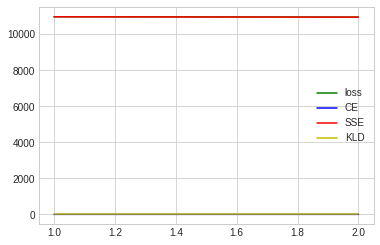

In [35]:
def visualize_training(losses, ce, sse, KLD, epochs):
    # Plot traing error
    fig = plt.figure()
    plt.plot(epochs, losses, '-g', label='loss')
    plt.plot(epochs, ce, '-b', label='CE')
    plt.plot(epochs, sse, '-r', label='SSE')
    plt.plot(epochs, KLD, '-y', label='KLD')
    plt.legend()
    plt.savefig(path + "loss_test.png")


In [34]:
def get_latents(): #TODOs: get right train_loader; what is right kld_w? 
    
    # Extracting the latent space
    train_test_loader = DataLoader(dataset=train_loader.dataset, batch_size=1, 
                                   drop_last=False, shuffle=False, 
                                   pin_memory=train_loader.pin_memory) # removed num_workers=1,

    latent, latent_var, cat_recon, cat_class, \
    con_recon, loss, likelihood = best_model.latent(train_test_loader, kld_w)

    con_recon = np.array(con_recon)
    con_recon = torch.from_numpy(con_recon)
    
    return latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood


latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood = get_latents(train_loader, kld_w)

====> Test set loss: 10929.7255


In [36]:
def calc_categorical_reconstruction_acc(cat_shapes, cat_class, can_recon, cat_recon_tmp):
   # Calculate the categorical reconstruction accuracy
   cat_true_recon = []
   cat_total_recon = []
   pos = 0
   for s in cat_shapes:
      n = s[1]
      cat_class_tmp = cat_class[:,pos:(n + pos)]
      cat_recon_tmp = cat_recon[:,pos:(n + pos)]

      missing_cat = cat_recon_tmp[cat_class_tmp == -1]
      diff_cat = cat_class_tmp - cat_recon_tmp

      diff_cat[diff_cat != 0] = -1
      true_cat = diff_cat[diff_cat == 0]
      false_cat = diff_cat[diff_cat != 0]
      cat_true = len(true_cat)/(float(diff_cat.size) - missing_cat.size)
      cat_true_recon.append(cat_true)
      diff_cat[diff_cat == 0] = 1
      diff_cat[diff_cat != 1] = 0
      cat_total_recon.append(np.count_nonzero(diff_cat, 1) / diff_cat.shape[1])
      pos += n
   return(cat_total_recon)
    

In [37]:
def calc_categorical_reconstruction_acc(con_shapes, con_recon, train_loader):
   # Calculate the continuous reconstruction accuracy
   total_shape = 0
   true_recon = []
   cos_values = []
   all_values = []
   for s in con_shapes:
      cor_con = list()
      cos_con = list()
      all_val = list()
      for n in range(0, con_recon.shape[0]):
         con_no_missing = train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         if len(con_no_missing) <= 1:
            all_val.append(np.nan)
            continue
         con_out_no_missing = con_recon[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         cor = pearsonr(con_no_missing, con_out_no_missing)[0]
         cor_con.append(cor)

         com = np.vstack([con_no_missing, con_out_no_missing])
         cos = cosine_similarity(com)[0,1]
         cos_con.append(cos)
         all_val.append(cos)

      cor_con = np.array(cor_con)
      cos_con = np.array(cos_con)
      cos_values.append(cos_con)
      all_values.append(np.array(all_val))
      true_recon.append(len(cos_con[cos_con >= 0.9]) / len(cos_con))
      total_shape += s
   return(all_values)



In [38]:
def plot_reconstruction_distribs(cat_total_recon, all_values):
    
    # Plot the reconstruction distributions
    df = pd.DataFrame(cat_total_recon + all_values, index = ['Clinical\n(categorical)', 'Genomics', 'Drug data', 'Clinical\n(continuous)', 'Diet +\n wearables','Proteomics','Targeted\nmetabolomics','Untargeted\nmetabolomics', 'Transcriptomics', 'Metagenomics'])
    df_t = df.T

    fig = plt.figure(figsize=(25,15))
    ax = sns.boxplot(data=df_t, palette="colorblind", width=0.7)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    plt.ylabel('Reconstruction accuracy', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    fig.subplots_adjust(bottom=0.2)
    plt.savefig(path + "reconstruction_accuracy.png")
    plt.close("all")

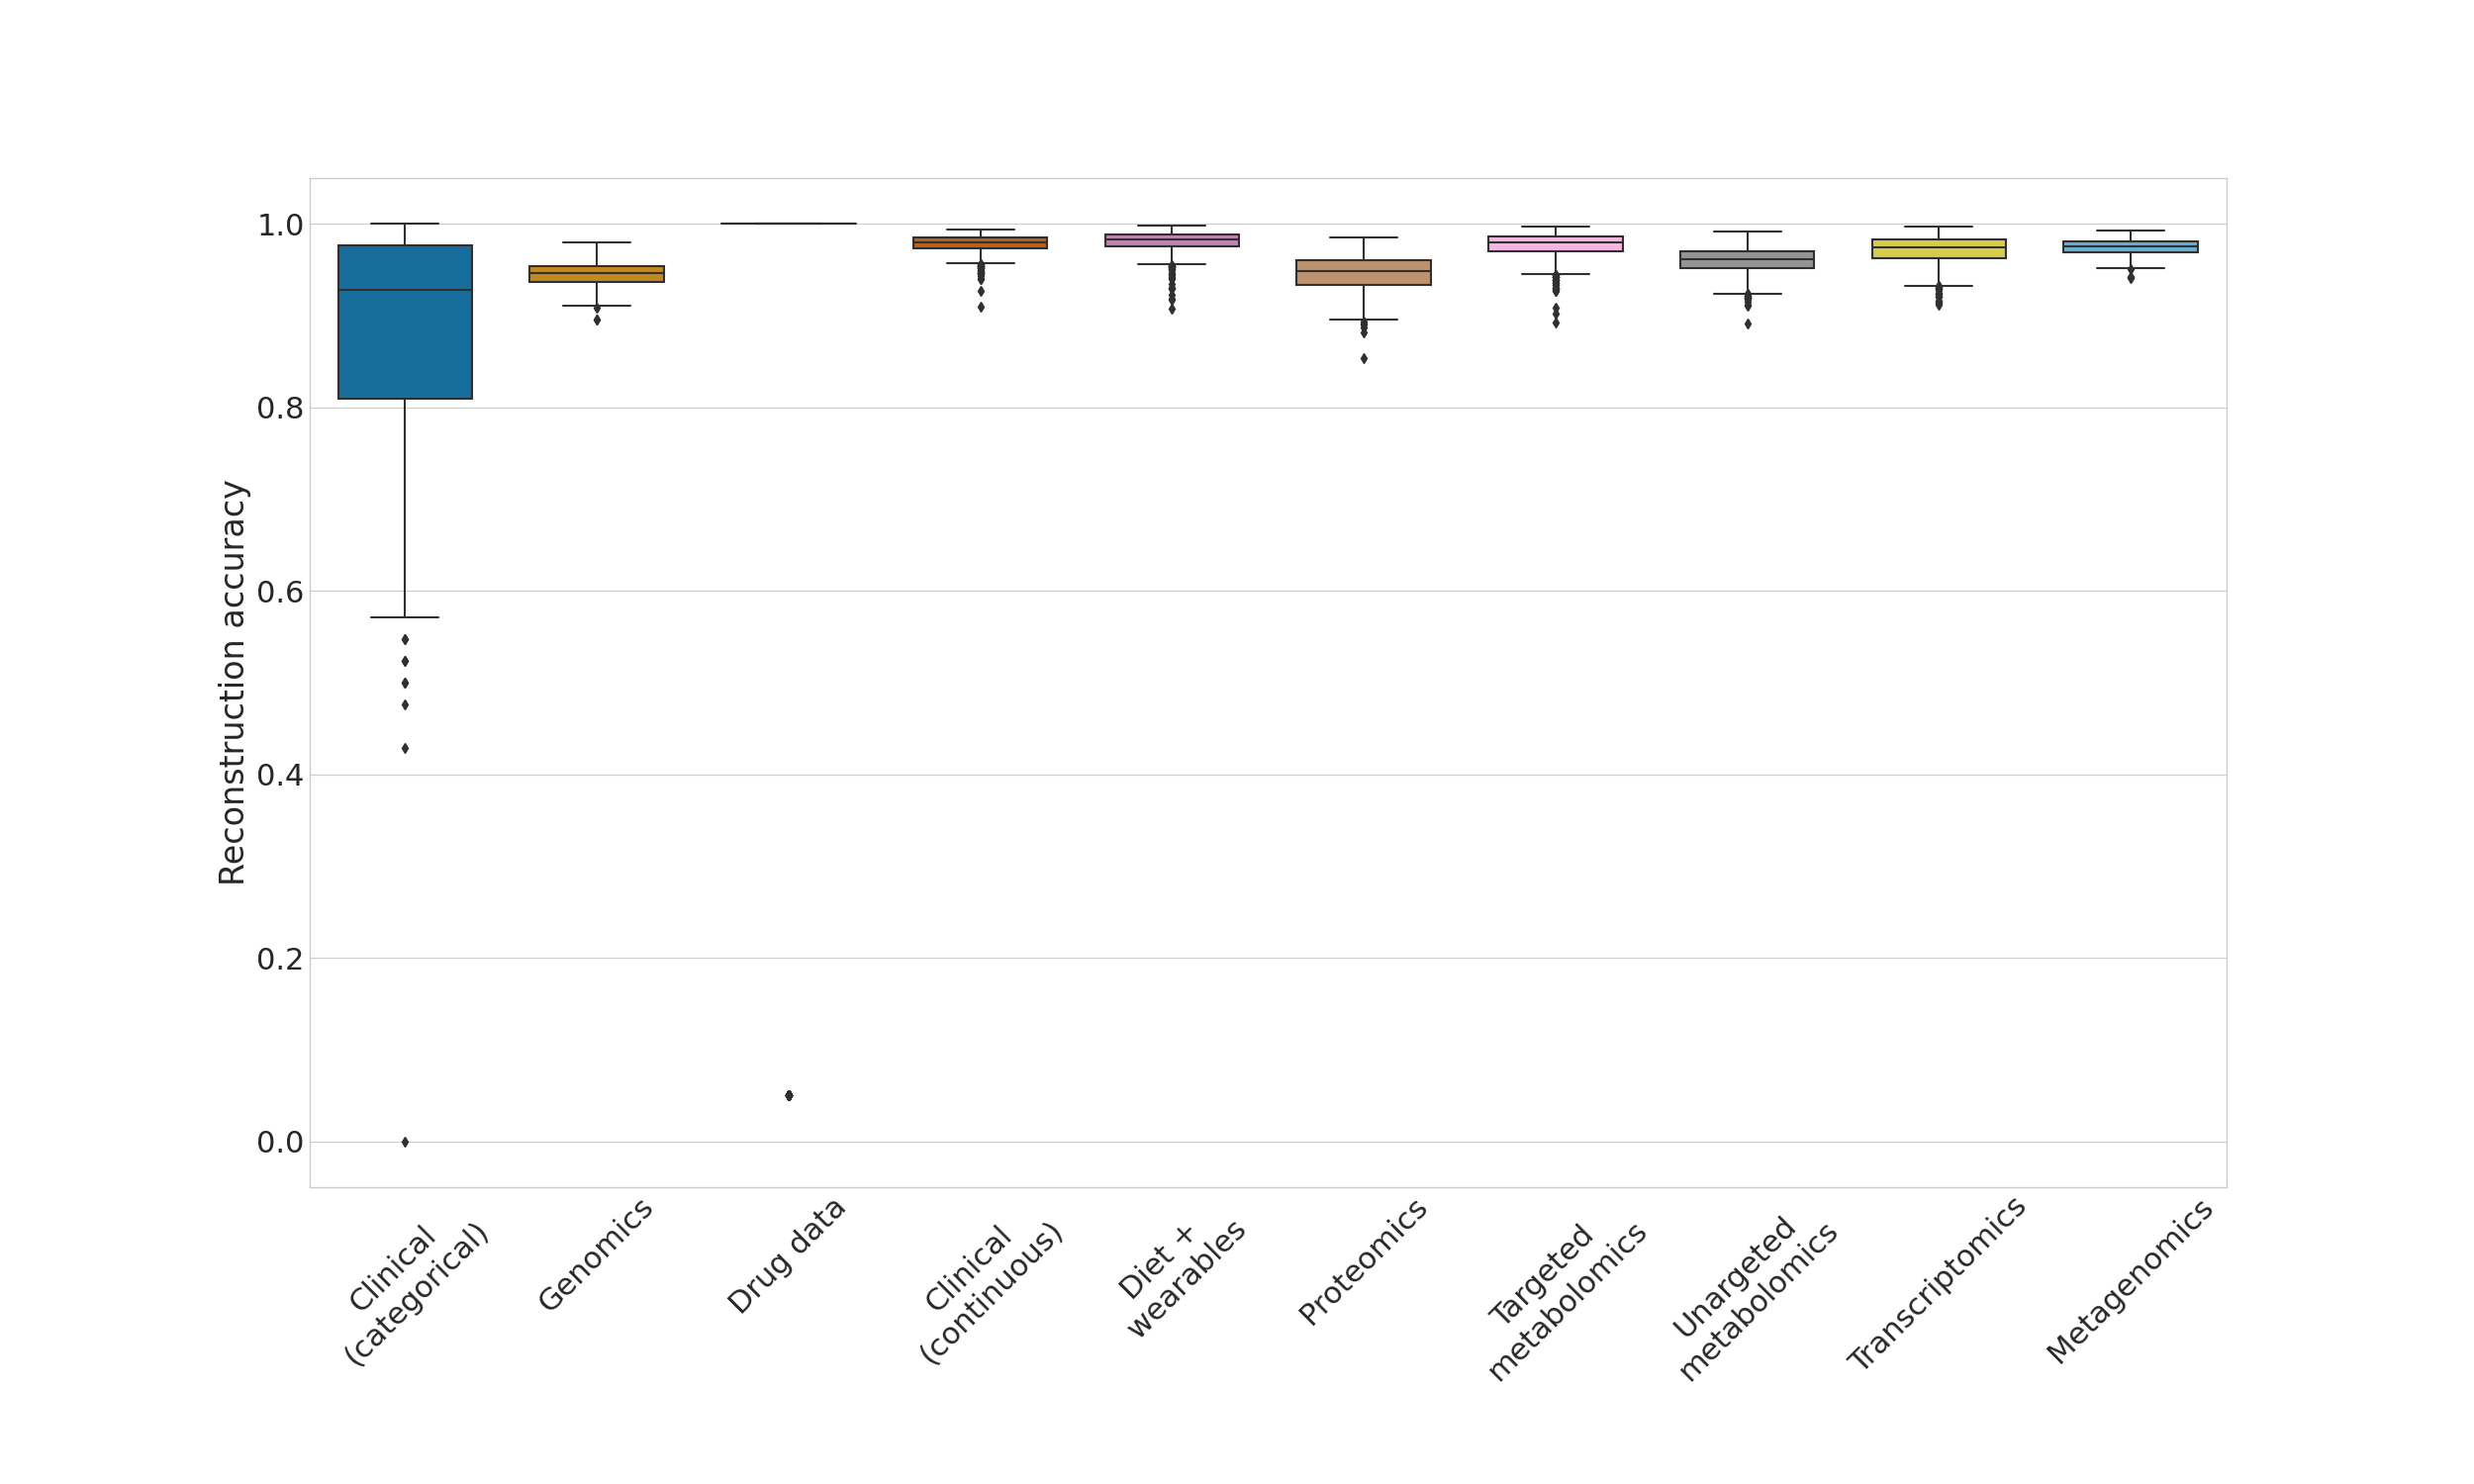

We can now plot the distributions of the features in the latent space in an UMAP embedding.  

In [39]:
#Todos: make folder creation as seperate function

def get_embedding(latent):
    results_folder = path + 'results/'
    isExist = os.path.exists(results_folder)
    if not isExist:
        os.makedirs(results_folder)


    # UMAP
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(latent)
    np.save(path + "results/embedding.npy", embedding)
    return(embedding)

embedding = get_embedding(latent)

In [47]:
# Get data
fasting_HbA1c = con[:,list(con_h).index("clinical_continuous_1")] #Todos: how to define it as a function
matsuda = con[:,list(con_h).index("clinical_continuous_2")]
metformin = np.argmax(drug[:,list(drug_h).index("drug_1")], axis =1)

0
{'0': <matplotlib.collections.PathCollection object at 0x7fc4305a89b0>, '1': <matplotlib.collections.PathCollection object at 0x7fc4305a8198>}
1
{'0': <matplotlib.collections.PathCollection object at 0x7fc4305a89b0>, '1': <matplotlib.collections.PathCollection object at 0x7fc4305a8198>}


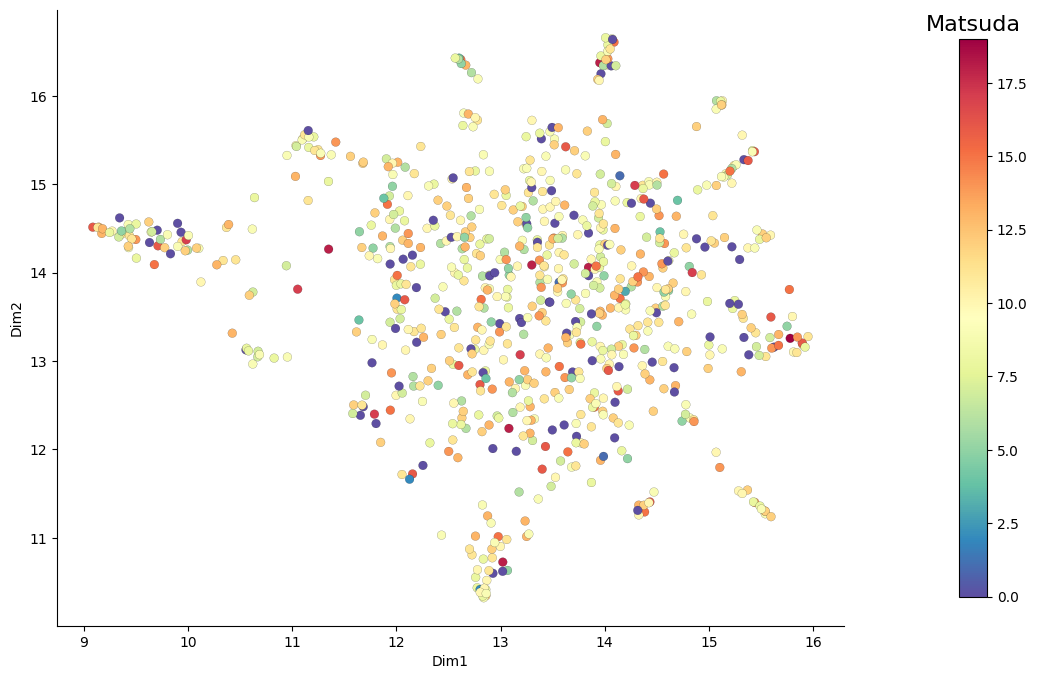

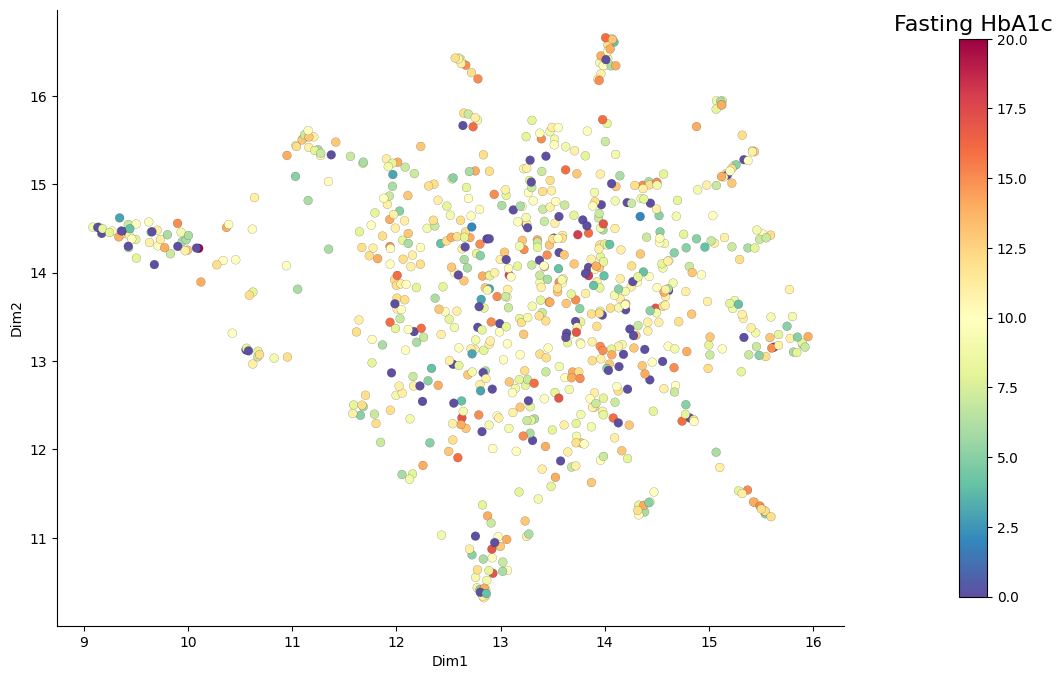

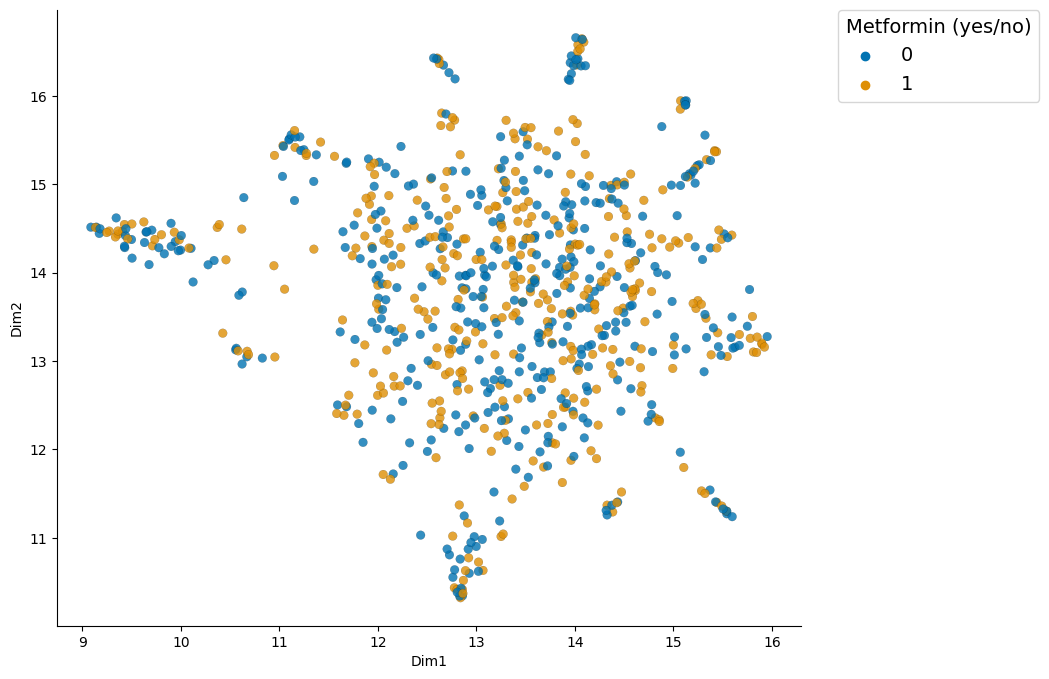

In [64]:
embedding_plot_float(embedding, matsuda[mask], "Matsuda", path + "results/umap_matsuda.png")
embedding_plot_float(embedding, fasting_HbA1c[mask], "Fasting HbA1c", path + "results/umap_fasting_HbA1c.png")
embedding_plot_discrete(embedding, metformin[mask], "Metformin (yes/no)", path + "results/umap_metformin.png")
# plt.close("all")

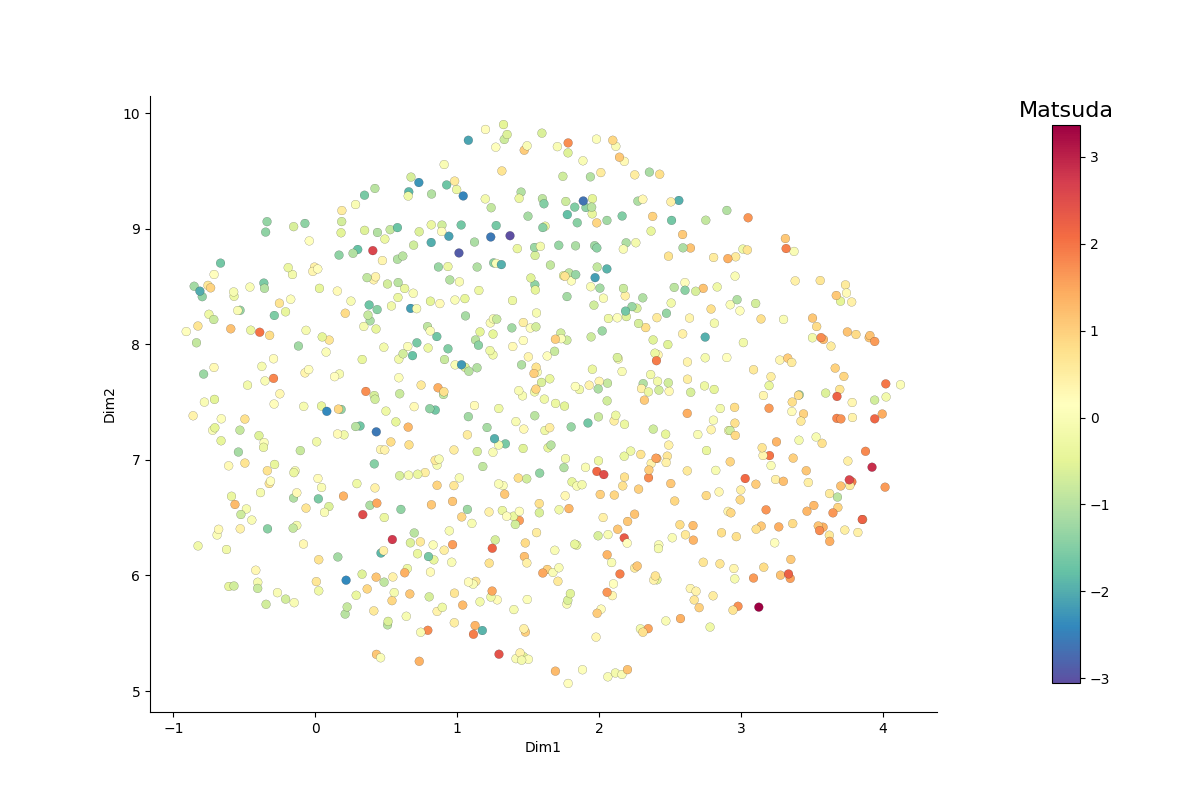

In [1]:
# Correlate embedding with variable 
pearsonr(embedding[:,0],matsuda)
pearsonr(embedding[:,1],matsuda)

pearsonr(embedding[:,0],fasting_HbA1c)
pearsonr(embedding[:,1],fasting_HbA1c)

NameError: name 'pearsonr' is not defined

Feature importance inspired by SHAP by changing one variable at the time to missing and calculate change in the latent space. 

In [ ]:
# from tqdm import tqdm
# Feature importance categorical

def get_feature_importance_categorical(train_loader, kld_w): #Which kld_w and train_loader

   all_diffs = []
   sum_diffs = []
   sum_diffs_abs = []
   total_diffs = []
   loss_cat = []
   pos = 0
   cat_in = train_loader.dataset.cat_all
   cat_shapes = train_loader.dataset.cat_shapes

   for cat_shape in cat_shapes:
      cat_dataset = cat_in[:, pos:(cat_shape[1]*cat_shape[2] + pos)]
      cat_dataset = np.array(cat_dataset.view(cat_in.shape[0], cat_shape[1], cat_shape[2]))
      for feature_index in tqdm(range(cat_shape[1])):

         new_cat = np.copy(cat_dataset)
         new_cat[:,feature_index,:] = 0
         new_cat = new_cat.reshape(new_cat.shape[0], -1)
         input_cat = np.copy(cat_in)
         input_cat[:, pos:(cat_shape[1]*cat_shape[2] + pos)] = new_cat
         input_cat = torch.from_numpy(input_cat)

         dataset = VAE_v2_1.Dataset(input_cat, train_loader.dataset.con_all, 
                                    train_loader.dataset.con_shapes, 
                                    train_loader.dataset.cat_shapes)

         new_loader = DataLoader(dataset, batch_size=1, 
                              drop_last=False, shuffle=False, 
                              pin_memory=train_loader.pin_memory) # removed num_workers=1,

         out = model.latent(new_loader, kld_w)

         new_latent_vector = out[0]
         diff = latent-new_latent_vector
         diff_abs = np.abs(latent-new_latent_vector)
         loss_cat.append(out[-1])
         all_diffs.append(diff)
         sum_diffs.append(np.sum(diff, axis = 1))
         sum_diffs_abs.append(np.sum(diff_abs, axis = 1))
         total_diffs.append(np.sum(diff))
         break #added

   all_diffs_cat_np = np.asarray(all_diffs)
   sum_diffs_cat_np = np.asarray(sum_diffs)
   sum_diffs_cat_abs_np = np.asarray(sum_diffs_abs)
   total_diffs_cat_np = np.asarray(total_diffs)
   return(all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np, total_diffs_cat_np)

all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np,\
        total_diffs_cat_np = get_feature_importance_categorical(train_loader, kld_w)

In [ ]:
def get_feature_importance_continuous(train_loader, kld_w):
# Feature importance continuous

    all_diffs_con = []
    sum_diffs_con = []
    sum_diffs_con_abs = []
    total_diffs_con = []
    loss_con = []
    con_shape = train_loader.dataset.con_all.shape[1]
    for feature_index in tqdm(range(con_shape)):

        new_con = np.array(train_loader.dataset.con_all)
        new_con[:,feature_index] = 0
        new_con = torch.from_numpy(new_con)

        dataset = VAE_v2_1.Dataset(train_loader.dataset.cat_all, new_con,
                                   train_loader.dataset.con_shapes,
                                   train_loader.dataset.cat_shapes)

        new_loader = DataLoader(dataset, batch_size=len(mask), 
                              drop_last=False, shuffle=False, 
                              pin_memory=train_loader.pin_memory) #removed num_workers=1,

        out = model.latent(new_loader, kld_w)

        new_latent_vector = out[0]
        loss_con.append(out[-1])
        diff_abs = np.abs(latent-new_latent_vector)
        diff = latent-new_latent_vector
        all_diffs_con.append(diff)
        sum_diffs_con.append(np.sum(diff, axis = 1))
        sum_diffs_con_abs.append(np.sum(diff_abs, axis = 1))
        total_diffs_con.append(np.sum(diff))
        break #added

    all_diffs_con_np = np.asarray(all_diffs_con)
    sum_diffs_con_np = np.asarray(sum_diffs_con)
    sum_diffs_con_abs_np = np.asarray(sum_diffs_con_abs)
    total_diffs_con_np = np.asarray(total_diffs_con)
    return(all_diffs_con_np, sum_diffs_con_np, sum_diffs_con_abs_np, total_diffs_con_np)

all_diffs_con_np, sum_diffs_con_np, sum_diffs_con_abs_np,\
            total_diffs_con_np = get_feature_importance_continuous(train_loader, kld_w)

In [ ]:
def save_feat_results(all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np, total_diffs_cat_np, 
                 all_diffs_con_np, sum_diffs_con_np, sum_diffs_con_abs_np, total_diffs_con_np):
    
    # Save results
    all_diffs_both = np.concatenate((all_diffs, all_diffs_con), axis=0)
    sum_diffs_both = np.concatenate((sum_diffs, sum_diffs_con), axis=0)
    sum_diffs_both_abs = np.concatenate((sum_diffs_abs, sum_diffs_con_abs), axis=0)
    total_diffs_both = np.concatenate((total_diffs, total_diffs_con), axis=0)

    np.save(path + "results/all_SHAP_diffs.npy", all_diffs_both)
    np.save(path + "results/sum_diffs.npy", sum_diffs_both)
    np.save(path + "results/sum_diffs_abs.npy", sum_diffs_both_abs)
    np.save(path + "results/total_diffs_final.npy", total_diffs_both)

    
save_feat_results(all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np, total_diffs_cat_np, 
                 all_diffs_con_np, sum_diffs_con_np,sum_diffs_con_abs_np, total_diffs_con_np)


In [16]:
con_names, cat_names = get_data_headers(path)


NameError: name 'train_loader' is not defined

In [ ]:
def plot_importance(path, sum_diffs, features, feature_names, fig_name):
    fig = plt.figure(figsize = (20,20))
    plot_importance.summary_plot(sum_diffs, features=features, 
                                 feature_names=feature_names, max_display = 25, 
                                 show = False, size = 30)
    plt.savefig(path + f"results/{fig_name}.png")

In [ ]:
# Plot categorical
cat_target = np.argmax(cat, 2)
cat_target[np.sum(cat, 2) == 0] = -1
geno_target = np.argmax(geno, 2)
geno_target[np.sum(geno, 2) == 0] = -1
drug_target = np.argmax(drug, 2)
drug_target[np.sum(drug, 2) == 0] = -1 # why this is needed

cat_target_all = np.concatenate((cat_target, geno_target, drug_target), axis=1) #TODOs: why cannot use train_loader.dataset.cat_all
sum_diffs_cat_np = np.transpose(sum_diffs_cat_np)


plot_importance(path=path,
               sum_diffs=sum_diffs_cat_np,
               features=cat_target_all,
               feature_names=cat_names
               fig_name='importance_SHAP_cat')



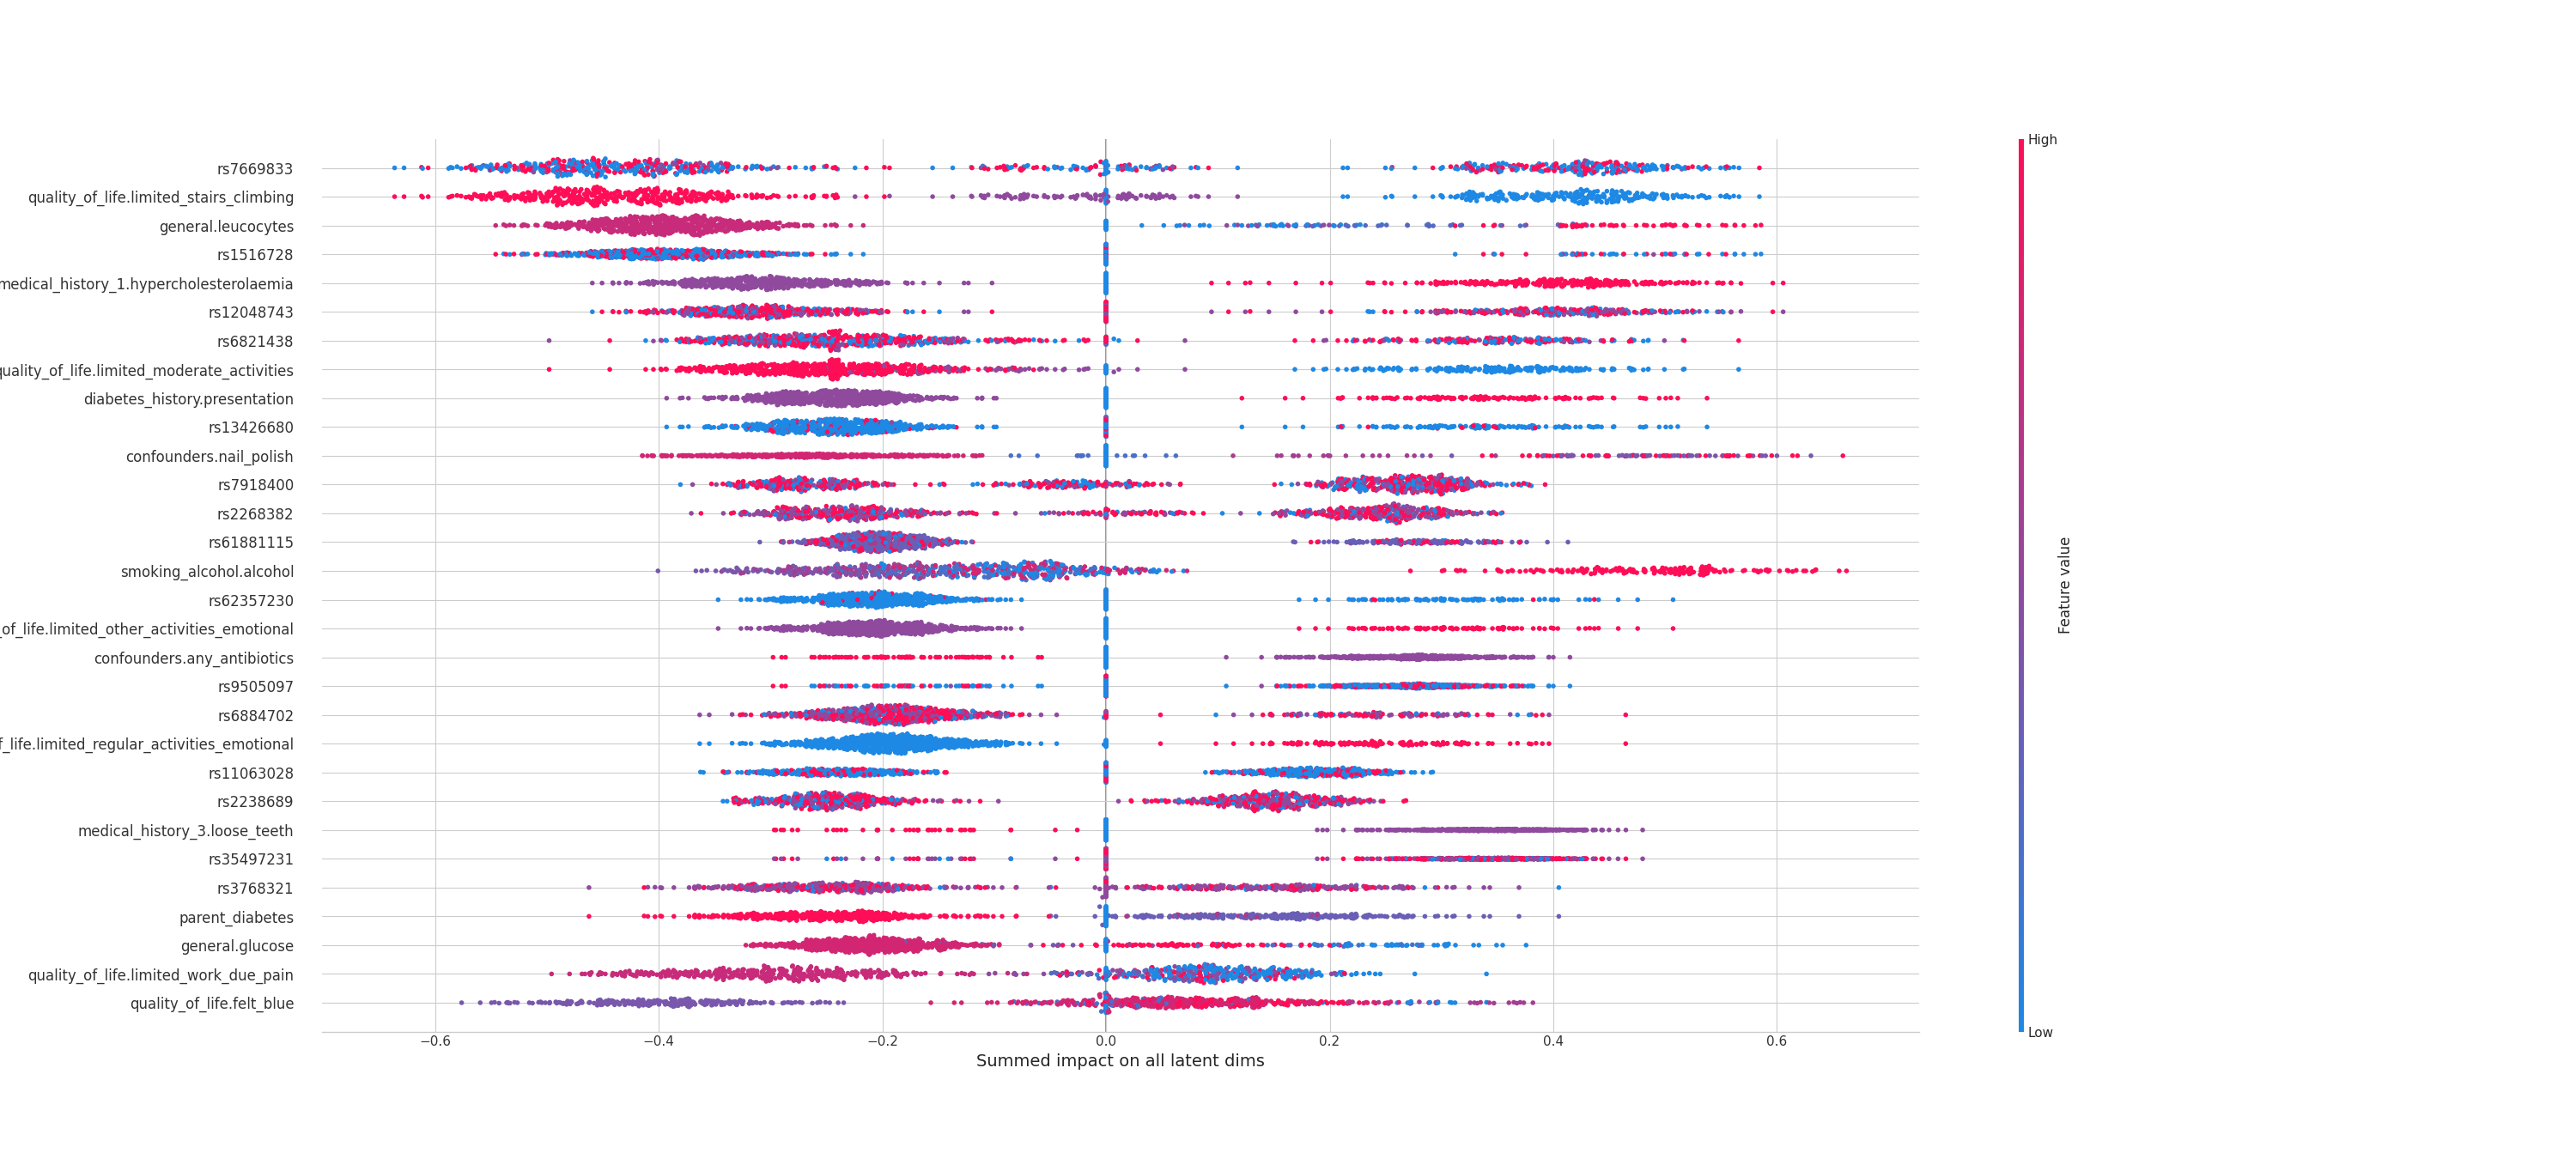

In [ ]:
# Plot continuous
con_all = np.asarray(train_loader.dataset.con_all)
sum_diffs_con_np = np.transpose(sum_diffs_con_np)

plot_importance(path=path,
               sum_diffs=sum_diffs_con_np,
               features=con_all,
               feature_names=con_names
               fig_name='importance_SHAP_con')



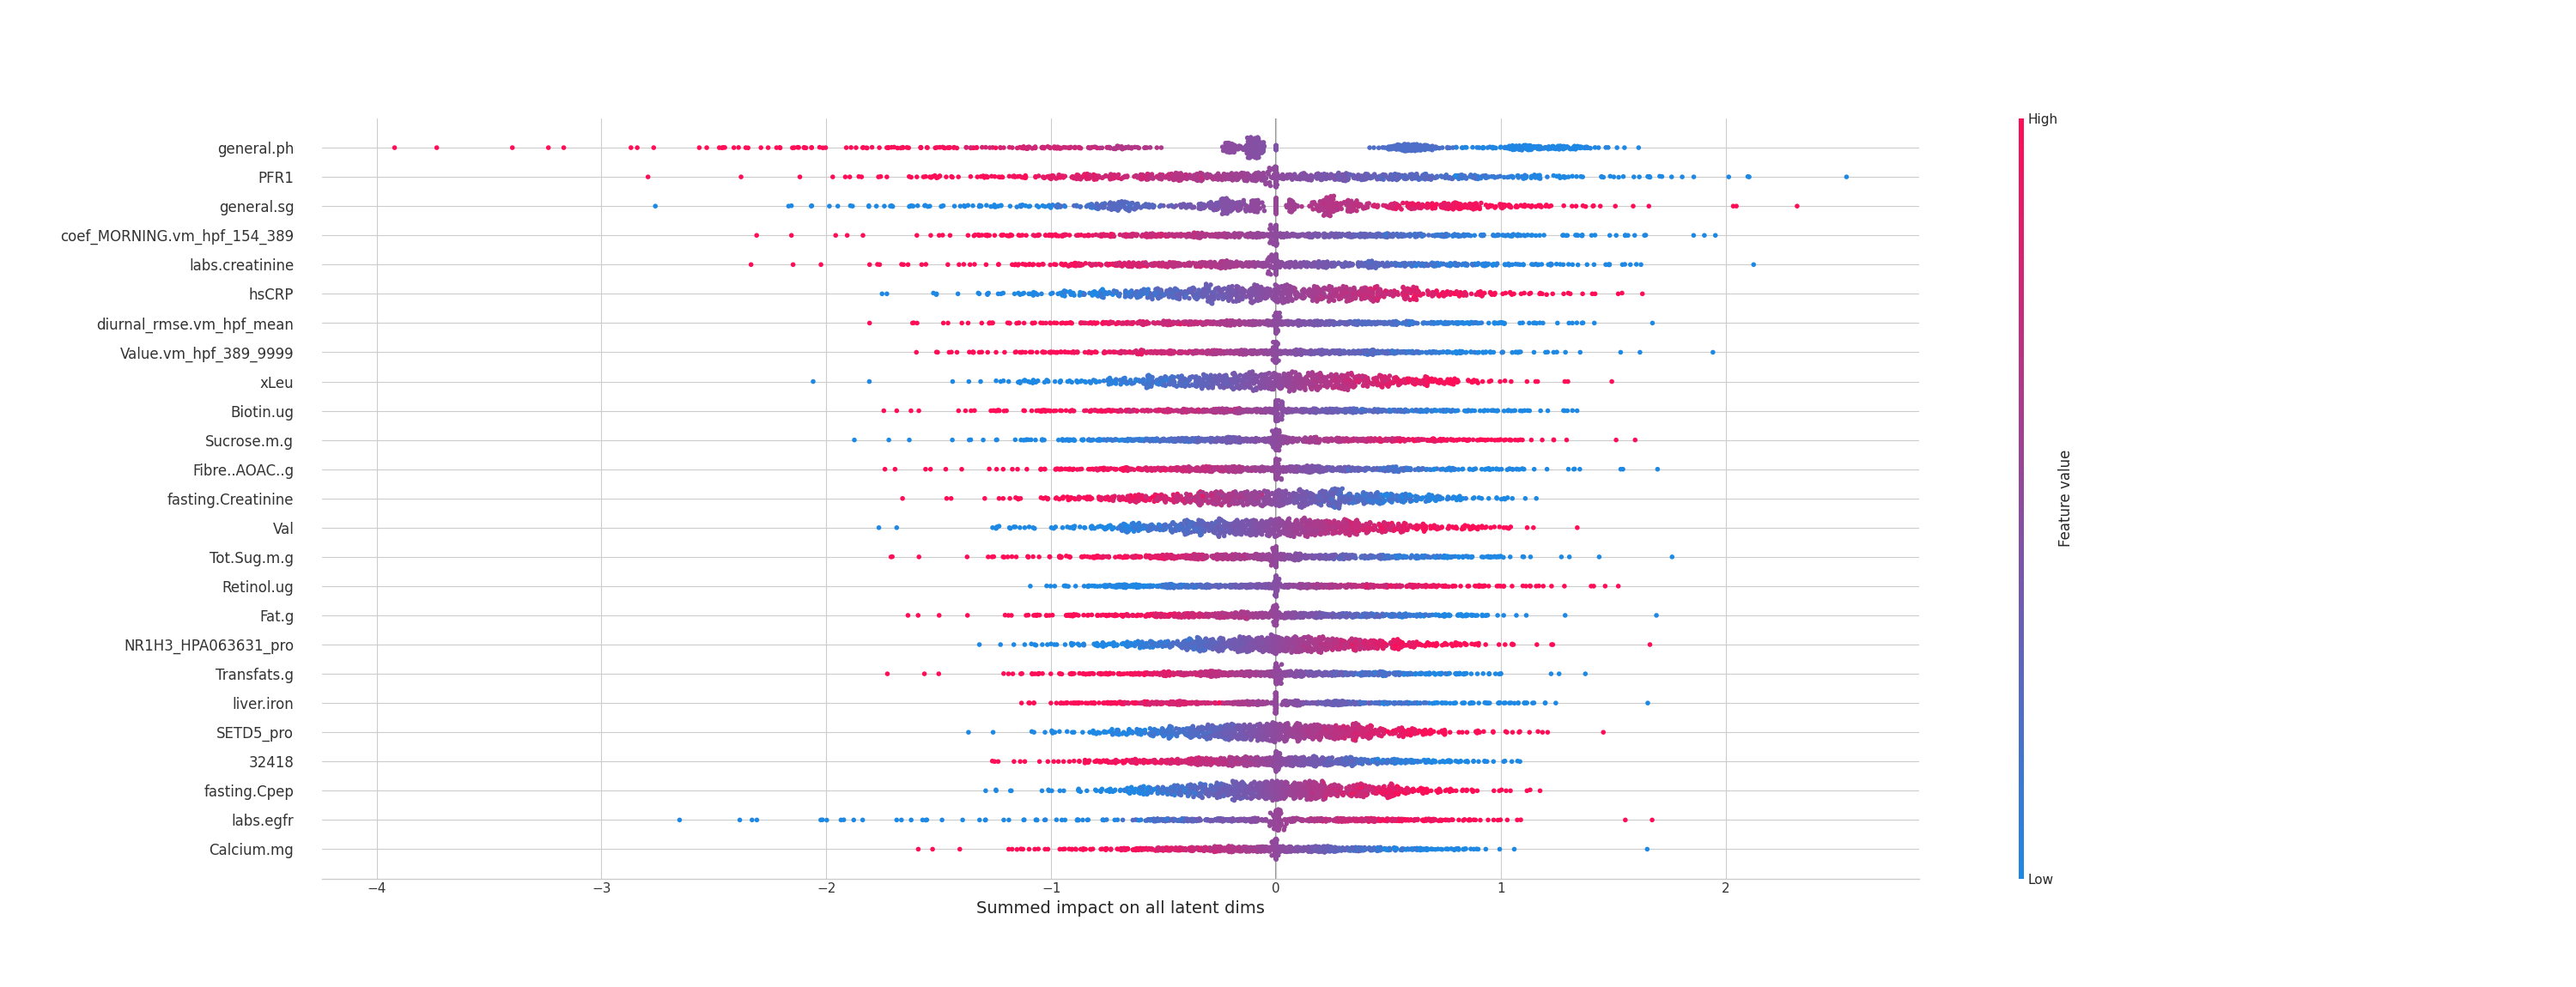

We also calculated the importance based on the weights from input to the first layer. This only represent the importance for defining the latent space (the encoder part). This was ony directy possible because our optimal setting only included one hidden layer. The categorical data is a sum of each input from the flatten one-hot encoding.

In [ ]:
def get_feat_importance_on_weights(model, train_loader, cat_shapes):
   #Based on weights

   # get weights
   w = np.array(model.encoderlayers[0].weight.data.to("cpu")) # TODOs: should it be trained or not trained model?

   w_sum = np.sum(np.abs(w), axis=0)

   w_sum_con = w_sum[train_loader.dataset.cat_all.shape[1]:]
   w_sum_cat = w_sum[0:train_loader.dataset.cat_all.shape[1]]

   # Get the sum of each input for each categorical one-hot vector
   w_sum_cat_final = []
   pos = 0
   for s in cat_shapes:
      n = s[1] * s[2]
      print(n)
      cat_w_sum_tmp = w_sum_cat[pos:(n + pos)]
      cat_w_sum_tmp = cat_w_sum_tmp.reshape(s[1], s[2])
      sum_d = np.sum(cat_w_sum_tmp, axis=1)
      w_sum_cat_final.extend(sum_d)


   feature_order_cat = np.flip(np.argsort(w_sum_cat_final))
   features_w_cat = cat_names[feature_order_cat]
   # Save the 
   tmp_pd = pd.DataFrame(np.array(w_sum_cat_final)[feature_order_cat], index=features_w_cat)
   tmp_pd.T.to_csv(path + "results/importance_w_cat.txt")

   feature_order = np.flip(np.argsort(w_sum_con))
   features_w_con = con_names[feature_order]

   tmp_pd = pd.DataFrame(w_sum_con[feature_order], index=features_w_con)
   tmp_pd.T.to_csv(path + "results/importance_w_con.txt")


get_feat_importance_on_weights(model, train_loader, cat_shapes)

After this the <i>identify_drug_assosiation.ipynb</i> can be run for extracting assosiations learned by the networks